# Finding the best local alignment in a database

The next idea we'll explore is database searching. In this context, what that means is that **we have some *query* sequence, and we want to know which *reference* sequence in a database it is most similar to**. This could be achieved in a few ways. It could be implemented with local alignment by representing the database as one long sequnence (if we build some functionality to support that into the algorithm), or with local or global alignment (depending on your application) by running our align function many times to search one *query* sequence against many *reference* sequences in the database. 

When our database starts getting hundreds of millions of bases long (as would be the case if we were searching against 97% OTUs from the Greengenes rRNA reference database), billions of bases long (as would be the case if we were searching against the human genome) or trillions of bases long (as would be the case if we were seraching against the NCBI non-redundant nucleotide database), **runtime becomes an important consideration**. 

In [1]:
%pylab inline
from __future__ import division, print_function
from time import time
from random import random, shuffle
from IPython.core import page
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from skbio.parse.sequences import parse_fasta
from skbio.alignment import local_pairwise_align_ssw

page.page = print

Populating the interactive namespace from numpy and matplotlib


The main function that we'll use for database searching is ``local_pairwise_align_ssw``. Remember that you can always get help with a function by passing it as an argument to ``help``:

In [2]:
help(local_pairwise_align_ssw)

Help on built-in function local_pairwise_align_ssw in module skbio.alignment._ssw_wrapper:

local_pairwise_align_ssw(...)
    Align query and target sequences with Striped Smith-Waterman.
    
    Parameters
    ----------
    sequence1 : str or BiologicalSequence
        The first unaligned sequence
    sequence2 : str or BiologicalSequence
        The second unaligned sequence
    
    Returns
    -------
    ``skbio.alignment.Alignment``
        The resulting alignment as an Alignment object
    
    Notes
    -----
    This is a wrapper for the SSW package [1]_.
    
    For a complete list of optional keyword-arguments that can be provided,
    see ``skbio.alignment.StripedSmithWaterman``.
    
    The following kwargs will not have any effect: `suppress_sequences` and
    `zero_index`
    
    If an alignment does not meet a provided filter, `None` will be returned.
    
    References
    ----------
    .. [1] Zhao, Mengyao, Wan-Ping Lee, Erik P. Garrison, & Gabor T.
       Mart

First, we're going to define some sequences in fasta format to serve as our reference database. These are derived from the [Greengenes](http://greengenes.secondgenome.com/) [13_8](ftp://greengenes.microbio.me/greengenes_release/gg_13_5/) database, and we're pulling them from the [QIIME default reference project](https://github.com/biocore/qiime-default-reference). We can load these as a list of sequences using ``skbio.parse.sequences.parse_fasta``, and count them by taking the length of the list.

In [3]:
from qiime_default_reference import get_reference_sequences 

reference_db = list(parse_fasta(get_reference_sequences()))
shuffle(reference_db)
print(len(reference_db))

99322


For the sake of runtime, let's work with only a random (approximately) 10% of these sequences.

In [4]:
temp_reference_db = []
fraction_to_keep = 0.10
for e in reference_db:
    if random() < fraction_to_keep:
        temp_reference_db.append(e)
reference_db = temp_reference_db
print(len(temp_reference_db))

10074


And we can next define our search function which takes a query sequence, a reference sequence, and an aligner function:

In [5]:
from iab.algorithms import local_alignment_search

%psource local_alignment_search

def local_alignment_search(query, reference_db, aligner=local_pairwise_align_ssw):
    best_score = 0.0
    best_match = None
    best_a1 = None
    best_a2 = None
    for seq_id, seq in reference_db:
        alignment = aligner(query, seq)
        score = alignment.score()
        if score > best_score:
            best_score = score
            best_match = seq_id
            best_a1 = str(alignment[0])
            best_a2 = str(alignment[1])
    return best_a1, best_a2, best_score, best_match



Next, let's define a query sequence to search against this database. We'll define `query1` to be an exact subsequence of one of the database sequences.

In [6]:
query1_id, query1 = reference_db[-1]
query1 = query1[100:300]

print(query1_id)
print(query1)

641637
CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA


And we can now perform some database searches. Experiment with different sequences to see how they align by modifying `query1` in the next cell and then executing it (remember that you'll need to execute all of the above cells before executing this one). 

Also, think about the runtime here. How many sequences are we searching, and how long are they? Does this strategy seem scalable?

In [7]:
start_time = time()
a1, a2, score, ref_id = local_alignment_search(query1, reference_db)
stop_time = time()

alignment_length = len(a1)
percent_id = 1 - (hamming(a1, a2)/alignment_length)

print(a1)
print(a2)
print(score)
print(ref_id)
print(alignment_length)
print(percent_id)
print("Runtime: %1.4f sec" % (stop_time - start_time))

CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
400.0
641637
200
1.0
Runtime: 6.4006 sec


In the next cell, I took a shorter exact match from `query1`. What is the effect on our database base search here? How can this happen?

In [8]:
query2 = query1[25:35]

start_time = time()
a1, a2, score, ref_id = local_alignment_search(query2, reference_db)
stop_time = time()

alignment_length = len(a1)
percent_id = 1 - (hamming(a1, a2)/alignment_length)

print(a1)
print(a2)
print(score)
print(ref_id)
print(alignment_length)
print(percent_id)
print("Runtime: %1.4f sec" % (stop_time - start_time))

CCTGATGGAT
CCTGATGGAT
20.0
4420771
10
1.0
Runtime: 4.4296 sec


## Using heuristics to reduce runtime for database searches

**As illustrated above, runtimes for performing pairwise alignments can be prohibitive for database searching.** The Smith-Waterman implementation we're using here, [SSW](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0082138), is very fast. As we covered in the prvious chapter, if we were to create an even faster implementation, that provide some initial help (it'd reduce our runtime by some factor $f$) but ultimately, we're still going to have a problem regardless of how big $f$ is, because **the runtime of the algorithm scales quadratically with sequence lengths**. Experiment with different values of $f$ to see how it changes the curve below. 

$f$ represents the fold-reduction in runtime (e.g., $f=2$ represents a two-fold reduction, or halving, of runtime, and $f=10$ equals a ten-fold reduction in runtime).

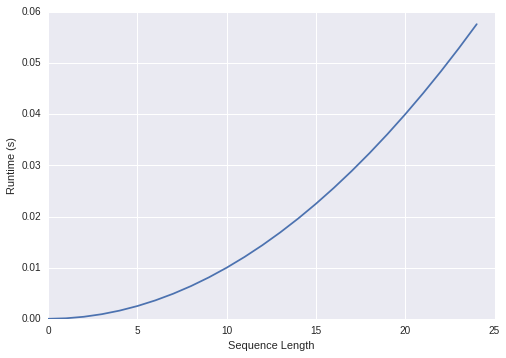

In [9]:
seq_lengths = range(25)
times = [t * t for t in range(25)]
f = 10000 # no scaling factor
times = [t / f for t in times]

plt.plot(range(25), times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

Database seearching is a slightly different problem however. There are a few different scenarios here:

1. we may have a database that is growing in size (for example, over months and years as more sequences are discovered);
2. we may have a fixed database, but increasingly be obtaining larger numbers of sequences that we want to search against that database;
3. or, the situation that we find ourselves in as of this writing: both. 

For the purposes of an exercise, think of the database as one long sequence that we want to align against and a collection of query sequence as another long sequence that we want to search. What do you expect a curve for each of the above to look like? 

**The core issue here is that it just takes too long to search each query sequence against the whole database. If we can search against a subset of the database by quickly deciding on certain sequences that are unlikely to match, that may help us to reduce runtime.** A heurtistic in this case would be a rule that we apply to determine which sequecnces we're going to align and which sequences we're not going to align. If we decided to not align against a given reference sequence, it becomes possible that we might miss the best alignment, so we want our heurtistics to be good to make that unlikely. So, when thinking about heurtistics, there are some important considerations:

1. How often do I fail to find the best alignment? 
2. Is my runtime reduced enough that I can tolerate not getting the best alignment this often? 

Let's look at a few heuristics, starting with a silly one first: we'll select a random `p` percent of database to align our query against. We'll start by defining `p` as 10%. 

In [10]:
random()

0.4038653970458407

In [11]:
from iab.algorithms import approximated_local_alignment_search_random
%psource approximated_local_alignment_search_random

def approximated_local_alignment_search_random(
        query, reference_db, p=0.10, aligner=local_pairwise_align_ssw):
    best_score = 0.0
    best_match = None
    best_a1 = None
    best_a2 = None
    for seq_id, seq in reference_db:
        if random() < p:
            alignment = aligner(query, seq)
            score = alignment.score()
            if score > best_score:
                best_score = score
                best_match = seq_id
                best_a1 = str(alignment[0])
                best_a2 = str(alignment[1])
    return best_a1, best_a2, best_score, best_match



Let's pass our initial `query1` (again, an exact match to a database sequence) and see if we get the right answer, and how much runtime is reduced.

In [12]:
start_time = time()
a1, a2, score, ref_id = approximated_local_alignment_search_random(query1, reference_db)
stop_time = time()

print(a1)
print(a2)
print(score)
print(ref_id)
print("Runtime: %1.4f sec" % (stop_time - start_time))

CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
CGGGTGAGTAATGTCTGGGAAACTGCCCGATGGAGGGGGATAACTACTGGAAACGGTAGCTAATACCGCATAACGTCGCAAGACCAAAGTGGGGGACCTTCGGGCCTCACACCATCGGATGTGCCCAGATGGGATTAGCTAGTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
330.0
539107
Runtime: 0.5973 sec


In this case, we know what the right answer is, so we can run this a bunch of times and figure out how often we'll get that right answer. In this case, we'll iterate over the first 100 sequences in the reference database and search 50 bases of each against the full database.

In [13]:
results = []

for query_id, query_seq in reference_db[:100]:
    query_seq = query_seq[50:101]
    a1, a2, score, ref_id = approximated_local_alignment_search_random(query_seq, reference_db)
    results.append(ref_id == query_id)
fraction_correct = results.count(True) / len(results)

print("We get the right answer %.2f%% of the time." % (fraction_correct * 100))

We get the right answer 9.00% of the time.


How much was the run time reduced here? How often were we right? What do you think: good heurtistic? 

Let's go with something a little smarter. **We can hypothesize that if the overall composition of a query sequence is different than the overall composition of a reference sequence, it's unlikely that the best alignment will result from that pairwise alignment.** One metric of sequence composition is GC content, so let's use that and only align against sequences whose GC content is within `p` percent of the query sequence.

In [14]:
from iab.algorithms import gc_content, approximated_local_alignment_search_gc
%psource gc_content

def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)



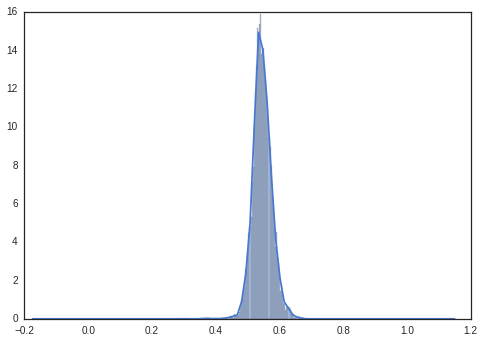

In [15]:
gc_contents = {}
for seq_id, seq in reference_db:
    gc_contents[seq_id] = gc_content(seq)

sns.set(style="white", palette="muted")
ax = sns.distplot(list(gc_contents.values()))

In [16]:
%psource approximated_local_alignment_search_gc

def approximated_local_alignment_search_gc(
        query, reference_db, reference_db_gc_contents, p=0.05,
        aligner=local_pairwise_align_ssw):
    query_gc = gc_content(query)
    best_score = 0.0
    best_match = None
    best_a1 = None
    best_a2 = None
    for seq_id, seq in reference_db:
        ref_gc = reference_db_gc_contents[seq_id]
        if ref_gc - p < query_gc < ref_gc + p:
            alignment = aligner(query, seq)
            score = alignment.score()
            if score > best_score:
                best_score = score
                best_match = seq_id
                best_a1 = str(alignment[0])
                best_a2 = str(alignment[1])
    return best_a1, best_a2, best_score, best_match



If we run our `query1` again, do we get the right answer? How much did we reduce runtime? Do you think this is a better or worse heurtistic? 

In [17]:
start_time = time()
a1, a2, score, ref_id = approximated_local_alignment_search_gc(query1, reference_db, gc_contents)
stop_time = time()

print(a1)
print(a2)
print(score)
print(ref_id)
print("Runtime: %1.4f sec" % (stop_time - start_time))

CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
400.0
641637
Runtime: 5.2422 sec


Let's make the alignment a litte harder by deleting some bases from our query. Now what happens?

In [ ]:
query2 = query1[:75] + query1[85:]
start_time = time()
a1, a2, score, ref_id = approximated_local_alignment_search_gc(query2, reference_db, gc_contents)
stop_time = time()

print(a1)
print(a2)
print(score)
print(ref_id)
print("Runtime: %1.4f sec" % (stop_time - start_time))

CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACG----------AAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
CGGGTGGGTAATGTCTGGGAAACTGCCTGATGGATGGGGATAACTACTGGAAACGGTAGCTTATACCGCATAACGTCGCAAGACCAAATAGGGGGACCTTCTGGCCTCTCACCTTCAGATGTGCCCACATGGTATTAGCTCTTAGGTGGGGTAATGGCTCACCTAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCA
357.0
641637
Runtime: 5.0460 sec


Again, let's look at how many times we'd be right if we ran this on a subsequence of each reference sequence in the database.

In [ ]:
results = []

for query_id, query_seq in reference_db[:20]:
    query_seq = query_seq[50:151]
    a1, a2, score, ref_id = approximated_local_alignment_search_gc(query_seq, reference_db, gc_contents)
    results.append(ref_id == query_id)
fraction_correct = results.count(True) / len(results)

print("We get the right answer %.2f%% of the time." % (fraction_correct * 100))

So this is looking a little better. It doesn't get our runtime quite as low, but we seem to get the right answer a lot more often. Our evaluation here was pretty limited though: our query sequences are always perfect subsequences of sequences in the reference database. If you were evaluating heuristics for a real-world application, what are some of the other things you might want to test?

**TODO**: Port k-mer composition comparison code from [multiple sequence alignment notebook](http://nbviewer.ipython.org/github/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/blob/master/algorithms/4-multiple-sequence-alignment.ipynb) to look at a third heuristic.

## Is my alignment "good"? Determining whether an alignment is statistically significant.

You may have noticed that the score you get back for an alignment isn't extremely informative. It's dependent on the query and reference sequence lengths (and possibly composition, depending on your substitution matrix). An important question then is: **is my alignment score good?**

Remember that an alignment of a pair of sequences represents a hypothesis about homology between those sequences. So when we are asking whether an alignment is good, what we really want to know is: **what fraction of the time would I obtain a score at least this good if my sequences are not homologous?** If this fraction is high, then our alignment is not good. If it's low, then our alignment is good. What is defined as high and low in this context is dependent on **how often you are willing to be wrong**. 

If being wrong 5% of the time is acceptable (i.e., you can tolerate a false positive, or calling a pair of sequences homologous when they are actually not, one in twenty times) then you'd set your *cut-off fraction* as 0.05. This fraction is usually call our **alpha**. You have to balance this with how often you can accept false negatives, or deciding that a pair of sequences are not homologous when they actually are. If alpha is high, then you will err on the side of false positives. If alpha is low, then you will err on the side of false negatives. **There is not a hard-and-fast rule for whether false positives or false negatives are better**. It's application specific, so you need to understand your application when making this decision.

In general, when might you prefer to have false positives? When might you prefer to have false negatives?

**In this section, we are going to empiricially determine if a pairwise alignment is better than we would expect by chance.** For each pair of sequences, we're going to align them to determine the score of the alignment, and then we're going to align pairs of sequences that are similar to the query and reference, but that we know are not homologous. We'll do this by *shuffling* or randomizing the order of the bases in the query sequences, and performing another pairwise alignment.

In [ ]:
from random import shuffle, choice
from collections import Counter

We're going to use python's `random.shuffle` and `random.choice` functions for this. `random.choice` randomly selects an element from a sequence, so we can use it to contruct a random sequence of length `n` as follows: 

In [ ]:
n = 10
seq = [choice('ACGT') for e in range(n)]
print("".join(seq), Counter(seq))

`random.shuffle` randomly re-orders the order of the elements in a sequence, but keeps the composition and length of the sequence the same. Run this next cell a few times to see the sequences that are generated.

In [ ]:
shuffle(seq)
print("".join(seq), Counter(seq))
shuffle(seq)
print("".join(seq), Counter(seq))

Let's generate a random query sequence. Then we'll generate 99 random variants of that sequence with ``shuffle`` and compute the pairwise alignment for each of those variants against the query sequence. We'll then look at the distribution of those scores.

In [ ]:
query_seq = [choice('ACGT') for e in range(40)]
''.join(query_seq)

In [ ]:
from iab.algorithms import generate_random_score_distribution
%psource generate_random_score_distribution

In [ ]:
random_scores = generate_random_score_distribution(query_seq, query_seq)
print(random_scores)

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(random_scores, facecolor='green', alpha=0.5, bins=range(0,100,1), normed=1)
plt.xlabel('Score')
plt.ylabel('Frequency')

Next, we'll compute the score for aligning the query sequence against itself. How does the actual score compare to the random distribution of scores? What does that suggest about our alignment?

In [ ]:
alignment = local_pairwise_align_ssw(query_seq, query_seq)
print(alignment.score())

# plot the distribution of random scores, but add in the actual score
n, bins, patches = plt.hist(random_scores + [alignment.score()], facecolor='green', alpha=0.5, bins=range(0,100,1), normed=1)
plt.xlabel('Score')
plt.ylabel('Frequency')

**Let's do this experiment again, but this time quanitfy the result by computing the fraction of the random alignments that achieve equal or better scores than the random sequences.**

In [ ]:
from iab.algorithms import fraction_better_or_equivalent_alignments
%psource fraction_better_or_equivalent_alignments

In [ ]:
print(fraction_better_or_equivalent_alignments(query_seq, query_seq))

What does this tell us about the quality of our alignment?

Let's now try this for some harder cases, where the query and subject sequences are not identical. 

First, let's generate a longer subject sequence at random. Then, we'll create a random query sequence and compare it. Since we're doing this in two random steps, we know that these sequences are not homologous. Does the resulting fraction reflect that?

In [ ]:
subject = "".join([choice('ACGT') for e in range(250)])
query = "".join([choice('ACGT') for e in range(250)])

print(query)
print(subject)

In [ ]:
print(fraction_better_or_equivalent_alignments(query,subject))

**We've now look at two extremes: where sequences are obviously homologous, and where sequences are obviously not homologous. Next, we'll explore the region between these.** We'll obscurce the homology of a pair of sequences by randomly introducing some number of substitutions to make them approximately ``percent_id`` equal. By doing this, we can explore how this strategy works for increasingly more distantly related pairs of sequences.

In [ ]:
def query_at_percent_id(percent_id, subject):
    result = []
    for b in subject:
        if random() < percent_id:
            result.append(b)
        else:
            # choose a base at random that is not the current base
            # i.e., simulate a substitution event
            result.append(choice([c for c in 'ACGT' if c != b]))
    return ''.join(result)

In [ ]:
q = query_at_percent_id(0.95,subject)
print(q)
print(subject)
print(fraction_better_or_equivalent_alignments(q,subject))

In [ ]:
q = query_at_percent_id(0.25,subject)
print(q)
print(subject)
print(fraction_better_or_equivalent_alignments(q,subject))

In this case we know that our input sequences are "homologous" because `query` is derived from `subject`. Our method detected that homology when `query` was roughly 95% identical to `subject` (because we got a low fraction) but did not detect that homology when `query` was roughly 25% identicial to `subject`. This gives us an idea of the limit of detection of this method, and is a **real-world problem that biologists face: as sequences are more divergent from one another, detecting homology becomes increasingly difficult.**

**If we want to gain some insight into our limit of detection, we can run a simulation.** If we simulate alignment of different pairs of sequences in steps of different percent identities, we can see where we start failing to observe homology. The following cell illustrates a very simplistic simulation, though this still takes a few minutes to run. 

What does this tell us about our limit of detection for homology? What are some things that we might want to do more robustly if we weren't as concerned about runtime?

In [ ]:
percent_ids = np.arange(0.0, 1.0, 0.05)
num_trials = 10
results = []

for percent_id in percent_ids:
    p_values = []
    for i in range(num_trials):
        subject = "".join([choice('ACGT') for e in range(250)])
        q = query_at_percent_id(percent_id,subject)
        p = fraction_better_or_equivalent_alignments(q,subject)
        p_values.append(p)
    results.append((percent_id, np.median(p_values), np.mean(p_values)))
pd.DataFrame(results, columns=["Percent id between query and subject", 
                               "Median p-value", "Mean p-value"])